In [1]:
# python libraries
from collections import namedtuple

# necessary libraries
import pandas as pd
import numpy as np
import pickle

# visualizations
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import LeaveOneOut

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# hyperparameters
from sklearn.model_selection import GridSearchCV

# pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

/root/anaconda3/lib/python3.7/site-packages/distributed/utils.py:139: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
def transform_ftr(row, column_name):
    if row[column_name] == 'H':
        return 1
    if row[column_name] == 'A':
        return -1
    else:
        return 0

In [3]:
football_data = pd.read_csv('data/2019-2020.csv')
columns = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC']
football_data =  football_data[columns]
football_data.FTR = football_data.apply(lambda row: transform_ftr(row, 'FTR'), axis=1)
football_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 11 columns):
HomeTeam    380 non-null object
AwayTeam    380 non-null object
FTHG        380 non-null int64
FTAG        380 non-null int64
FTR         380 non-null int64
HS          380 non-null int64
AS          380 non-null int64
HST         380 non-null int64
AST         380 non-null int64
HC          380 non-null int64
AC          380 non-null int64
dtypes: int64(9), object(2)
memory usage: 32.7+ KB


In [4]:
# Lets split the data and stratify by the Full Time Result
X = football_data.drop('FTR', axis=1).copy()
y = football_data['FTR'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [5]:
y.value_counts() / len(y) * 100

 1    45.263158
-1    30.526316
 0    24.210526
Name: FTR, dtype: float64

In [6]:
y_train.value_counts() / len(y_train) * 100

 1    45.263158
-1    30.526316
 0    24.210526
Name: FTR, dtype: float64

In [7]:
# Average Home and Away Goals 
average_ht_goals = X_train.FTHG.sum() / X_train.shape[0]
average_at_goals = X_train.FTAG.sum() / X_train.shape[0]
average_ht_conceded = average_at_goals
average_at_conceded = average_ht_goals
print('Average goals scored by home team: {}'.format(average_ht_goals))
print('Average goals scored by away team: {}'.format(average_at_goals))
print('Average goals conceded by home team: {}'.format(average_ht_conceded))
print('Average goals conceded by away team: {}'.format(average_at_conceded))

Average goals scored by home team: 1.4807017543859649
Average goals scored by away team: 1.1508771929824562
Average goals conceded by home team: 1.1508771929824562
Average goals conceded by away team: 1.4807017543859649


## Feature Engineering

In [8]:
X_train.head()

,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,AC
335,West Ham,Burnley,0,1,21,8,5,4,10,3
190,Newcastle,Everton,1,2,20,22,5,9,5,8
270,Norwich,Leicester,1,0,11,19,6,4,6,7
174,Newcastle,Crystal Palace,1,0,8,16,3,4,4,5
99,Norwich,Man United,1,3,10,21,3,11,1,10


In [9]:
ht = X_train.groupby('HomeTeam')
at = X_train.groupby('AwayTeam')

df = pd.DataFrame(columns=['Teams', 'HTG', 'ATG', 'HTC', 'ATC', 'HAS', 'AAS', 'HDS', 'ADS'])
teams = ht.groups.keys()
num_games = X_train.shape[0] / 20
df['Teams'] = teams
df['HTG'] = ht.FTHG.sum().values
df['ATG'] = at.FTAG.sum().values
df['HTC'] = ht.FTAG.sum().values
df['ATC'] = at.FTHG.sum().values
df['HAS'] = df['HTG'] / num_games / average_ht_goals
df['AAS'] = df['ATG'] / num_games / average_at_goals
df['HDS'] = df['HTC'] / num_games / average_at_conceded
df['ADS'] = df['ATC'] / num_games / average_ht_conceded
df

,Teams,HTG,ATG,HTC,ATC,HAS,AAS,HDS,ADS
0,Arsenal,31,12,20,17,1.469194,0.731707,0.947867,1.036585
1,Aston Villa,20,11,29,25,0.947867,0.670732,1.374408,1.524390
2,Bournemouth,21,16,29,23,0.995261,0.975610,1.374408,1.402439
3,Brighton,13,12,17,21,0.616114,0.731707,0.805687,1.280488
4,Burnley,15,14,19,20,0.710900,0.853659,0.900474,1.219512
5,Chelsea,22,26,11,26,1.042654,1.585366,0.521327,1.585366
6,Crystal Palace,12,13,15,25,0.568720,0.792683,0.710900,1.524390
7,Everton,21,18,20,32,0.995261,1.097561,0.947867,1.951220
8,Leicester,25,31,11,22,1.184834,1.890244,0.521327,1.341463
9,Liverpool,42,19,11,9,1.990521,1.158537,0.521327,0.548780


/root/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/root/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/root/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/root/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecatio

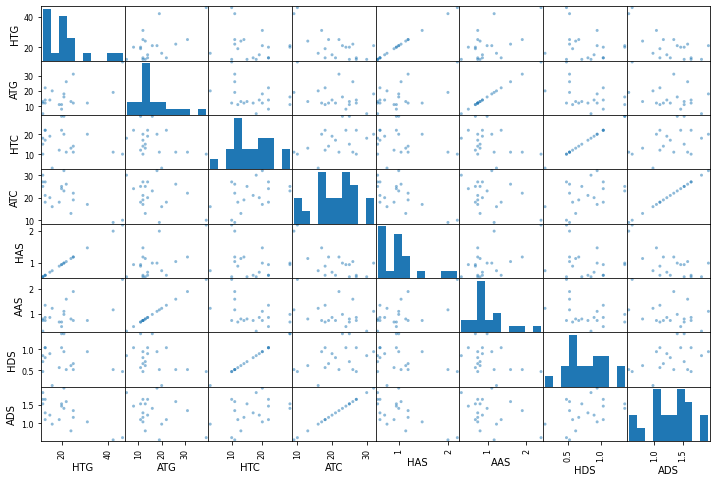

In [10]:
scatter_matrix(df.drop('Teams', axis=1), figsize=(12, 8))
plt.show()

We can see some correlations among the features, we take care of this situation by removing features that are correlated

In [11]:
HAS = []
AAS = []
HDS = []
ADS = []
HXG = []
AXG = []

for idx, row in X_train.iterrows():
    HAS.append(df[df['Teams'] == row['HomeTeam']]['HAS'].values[0])
    AAS.append(df[df['Teams'] == row['HomeTeam']]['AAS'].values[0])
    HDS.append(df[df['Teams'] == row['HomeTeam']]['HDS'].values[0])
    ADS.append(df[df['Teams'] == row['HomeTeam']]['ADS'].values[0])
X_train.loc[:, 'HAS'] = HAS
X_train.loc[:, 'AAS'] = AAS
X_train.loc[:, 'HDS'] = HDS
X_train.loc[:, 'ADS'] = ADS

X_train.loc[:, 'HXG'] = np.array(HAS) * np.array(ADS) * average_ht_goals
X_train.loc[:, 'AXG'] = np.array(AAS) * np.array(HDS) * average_at_goals
X_train.head()

/root/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/root/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,AC,HAS,AAS,HDS,ADS,HXG,AXG
335,West Ham,Burnley,0,1,21,8,5,4,10,3,0.616114,0.853659,1.042654,1.646341,1.501926,1.024362
190,Newcastle,Everton,1,2,20,22,5,9,5,8,0.568720,0.731707,0.473934,1.646341,1.386393,0.399102
270,Norwich,Leicester,1,0,11,19,6,4,6,7,0.568720,0.304878,0.853081,1.829268,1.540436,0.299327
174,Newcastle,Crystal Palace,1,0,8,16,3,4,4,5,0.568720,0.731707,0.473934,1.646341,1.386393,0.399102
99,Norwich,Man United,1,3,10,21,3,11,1,10,0.568720,0.304878,0.853081,1.829268,1.540436,0.299327


In [12]:
# Recent k performance
k = 3
X_train = X_train.reset_index(drop=True)

for idx in range(X_train.shape[0]-1, -1, -1):
    row = X_train.iloc[idx]
    ht = row.HomeTeam
    at = row.AwayTeam
    
    ht_stats = X_train.loc[idx:][(X_train.HomeTeam == ht) | (X_train.AwayTeam == ht)].head(k)
    at_stats = X_train.loc[idx:][(X_train.HomeTeam == at) | (X_train.AwayTeam == at)].head(k)
    
    X_train.at[idx, 'PastFTHG'] =  (ht_stats[ht_stats.HomeTeam == ht].FTHG.sum() + ht_stats[ht_stats.AwayTeam == ht].FTAG.sum())
    X_train.at[idx, 'PastFTAG'] =  (at_stats[at_stats.HomeTeam == at].FTHG.sum() + at_stats[at_stats.AwayTeam == at].FTAG.sum())
    X_train.at[idx, 'PastHS'] =  (ht_stats[ht_stats.HomeTeam == ht].HS.sum() + ht_stats[ht_stats.AwayTeam == ht].AS.sum())
    X_train.at[idx, 'PastAS'] =  (at_stats[at_stats.HomeTeam == at].HS.sum() + at_stats[at_stats.AwayTeam == at].AS.sum())
    X_train.at[idx, 'PastHST'] =  (ht_stats[ht_stats.HomeTeam == ht].HST.sum() + ht_stats[ht_stats.AwayTeam == ht].AST.sum())
    X_train.at[idx, 'PastAST'] =  (at_stats[at_stats.HomeTeam == at].HST.sum() + at_stats[at_stats.AwayTeam == at].AST.sum())
X_train.tail(20)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,AC,...,HDS,ADS,HXG,AXG,PastFTHG,PastFTAG,PastHS,PastAS,PastHST,PastAST
265,West Ham,Everton,1,1,12,11,6,3,7,6,...,1.042654,1.646341,1.501926,1.024362,5.0,4.0,39.0,41.0,20.0,16.0
266,Bournemouth,Watford,0,3,10,18,1,6,5,5,...,1.374408,1.402439,2.066752,1.543194,3.0,4.0,23.0,54.0,8.0,12.0
267,Man City,Burnley,5,0,19,1,7,0,3,1,...,0.473934,0.609756,1.968335,1.297082,11.0,3.0,60.0,29.0,21.0,8.0
268,Sheffield United,Arsenal,1,0,8,9,2,3,7,12,...,0.568720,1.097561,1.463415,0.439012,3.0,7.0,19.0,34.0,6.0,13.0
269,Everton,Bournemouth,1,3,13,13,5,7,2,5,...,0.947867,1.951220,2.875481,1.197306,3.0,3.0,39.0,13.0,16.0,7.0
270,Watford,Crystal Palace,0,0,13,3,3,0,6,2,...,1.042654,1.463415,2.053915,0.585350,1.0,3.0,36.0,22.0,6.0,7.0
271,Everton,Newcastle,2,2,17,8,8,2,6,4,...,0.947867,1.951220,2.875481,1.197306,2.0,2.0,26.0,24.0,11.0,5.0
272,Arsenal,Newcastle,4,0,15,10,7,2,5,6,...,0.947867,1.036585,2.255028,0.798204,8.0,0.0,32.0,16.0,14.0,3.0
273,West Ham,Arsenal,1,3,11,10,4,3,4,3,...,1.042654,1.646341,1.501926,1.024362,4.0,6.0,27.0,33.0,14.0,16.0
274,Sheffield United,Aston Villa,2,0,7,8,3,0,3,2,...,0.568720,1.097561,1.463415,0.439012,2.0,2.0,11.0,24.0,4.0,3.0


In [13]:
X_train['PastGoalDiff'] = X_train['PastFTHG'] - X_train['PastFTAG']
X_train['PastShotsDiff'] = X_train['PastHS'] - X_train['PastAS']
X_train['PastShotsOnTargetDiff'] = X_train['PastHST'] - X_train['PastAST']
X_train.drop(['PastFTHG', 'PastFTAG', 'PastHS', 'PastAS', 'PastHST', 'PastAST'], axis=1, inplace=True)

In [14]:
X_train_1 = X_train.copy()
X_train_1 = X_train_1[['HAS', 'AAS', 'HDS', 'ADS', 'HXG', 'AXG', 'PastGoalDiff', 'PastShotsDiff', 'PastShotsOnTargetDiff']]
scaler = StandardScaler()
X_train_1 = scaler.fit_transform(X_train_1)
pickle.dump(scaler, open('myscaler.pkl', 'wb'))
X_train_1

array([[-0.93419564, -0.29073395,  0.7916379 , ...,  0.20347557,
         0.73706699,  0.92318476],
       [-1.0415528 , -0.54647215, -1.04513388, ..., -0.0794051 ,
        -0.4679943 ,  0.06655518],
       [-1.0415528 , -1.44155585,  0.17938064, ...,  0.76923693,
        -0.63232083,  0.80080911],
       ...,
       [-1.0415528 , -0.41860305, -0.27981231, ..., -0.36228578,
        -0.13934122, -0.30057178],
       [ 0.99823324, -0.54647215,  0.48550927, ...,  1.0521176 ,
         0.18931186,  0.67843345],
       [-0.18269552, -1.05794855,  0.7916379 , ..., -0.64516645,
         0.29886289, -0.91245006]])

In [15]:
knn_clf = KNeighborsClassifier(n_neighbors=10)
knn_clf.fit(X_train_1, y_train)
scores = cross_val_score(knn_clf, X_train_1, y_train, cv=3)
np.mean(scores)

0.5333333333333333

In [16]:
class DumbClassifier(BaseEstimator, TransformerMixin):
    """This classifier predicts 1 only"""
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.ones((len(X)))

In [17]:
dumb_clf = DumbClassifier()
np.mean(cross_val_score(dumb_clf, X_train_1, y_train, cv=3, scoring='accuracy'))

0.45263157894736844

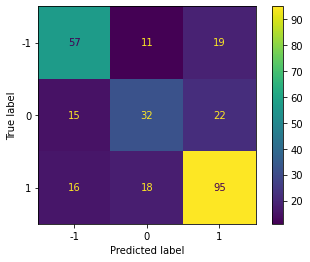

In [18]:
plot_confusion_matrix(knn_clf, X_train_1, y_train)

In [19]:
y_pred = cross_val_predict(knn_clf, X_train_1, y_train, cv=3)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          -1       0.54      0.59      0.56        87
           0       0.33      0.25      0.28        69
           1       0.60      0.65      0.62       129

    accuracy                           0.53       285
   macro avg       0.49      0.49      0.49       285
weighted avg       0.52      0.53      0.52       285



#### Away Report
- The ***KNN*** model could only classified 39% of the away wins correctly out of all away wins prediction it made(precision)
- The ***KNN*** model could only classified 46% of the away wins correctly out of all away wins present in the data(recall)

#### Draw Report
- The ***KNN*** model could only classified 31% of the draws correctly out of all draw prediction it made(precision)
- The ***KNN*** model could only classified 25% of the draws correctly out of all draw present in the data(recall)

#### Home Report
- The ***KNN*** model could only classified 54% of the home wins correctly out of all home wins prediction it made(precision)
- The ***KNN*** model could only classified 53% of the home wins correctly out of all home wins present in the data(recall)


We obtained an accuracy score of 44% which is no better than a "dumb classifier" that predicts only ***Home***

# Training Pipeline

In [20]:
class DataPreparation(BaseEstimator, TransformerMixin):
    
    def __init__(self, k=3):
        self.k = k
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        average_ht_goals = X.FTHG.sum() / X.shape[0]
        average_at_goals = X.FTAG.sum() / X.shape[0]
        average_ht_conceded = average_at_goals
        average_at_conceded = average_ht_goals
        
        ht = X.groupby('HomeTeam')
        at = X.groupby('AwayTeam')

        df = pd.DataFrame(columns=['Teams', 'HTG', 'ATG', 'HTC', 'ATC', 'HAS', 'AAS', 'HDS', 'ADS'])
        teams = ht.groups.keys()
        num_games = X.shape[0] / 20
        df['Teams'] = teams
        df['HTG'] = ht.FTHG.sum().values
        df['ATG'] = at.FTAG.sum().values
        df['HTC'] = ht.FTAG.sum().values
        df['ATC'] = at.FTHG.sum().values
        df['HAS'] = df['HTG'] / num_games / average_ht_goals
        df['AAS'] = df['ATG'] / num_games / average_at_goals
        df['HDS'] = df['HTC'] / num_games / average_at_conceded
        df['ADS'] = df['ATC'] / num_games / average_ht_conceded
        
        HAS = []
        AAS = []
        HDS = []
        ADS = []
        HXG = []
        AXG = []

        for idx, row in X.iterrows():
            HAS.append(df[df['Teams'] == row['HomeTeam']]['HAS'].values[0])
            AAS.append(df[df['Teams'] == row['HomeTeam']]['AAS'].values[0])
            HDS.append(df[df['Teams'] == row['HomeTeam']]['HDS'].values[0])
            ADS.append(df[df['Teams'] == row['HomeTeam']]['ADS'].values[0])
        X.loc[:, 'HAS'] = HAS
        X.loc[:, 'AAS'] = AAS
        X.loc[:, 'HDS'] = HDS
        X.loc[:, 'ADS'] = ADS

        X.loc[:, 'HXG'] = np.array(HAS) * np.array(ADS) * average_ht_goals
        X.loc[:, 'AXG'] = np.array(AAS) * np.array(HDS) * average_at_goals
        

        for idx in range(X.shape[0]-1, -1, -1):
            row = X.iloc[idx]
            ht = row.HomeTeam
            at = row.AwayTeam

            ht_stats = X.loc[idx:][(X.HomeTeam == ht) | (X.AwayTeam == ht)].head(self.k)
            at_stats = X.loc[idx:][(X.HomeTeam == at) | (X.AwayTeam == at)].head(self.k)

            X.at[idx, 'PastFTHG'] =  (ht_stats[ht_stats.HomeTeam == ht].FTHG.sum() + ht_stats[ht_stats.AwayTeam == ht].FTAG.sum())
            X.at[idx, 'PastFTAG'] =  (at_stats[at_stats.HomeTeam == at].FTHG.sum() + at_stats[at_stats.AwayTeam == at].FTAG.sum())
            X.at[idx, 'PastHS'] =  (ht_stats[ht_stats.HomeTeam == ht].HS.sum() + ht_stats[ht_stats.AwayTeam == ht].AS.sum())
            X.at[idx, 'PastAS'] =  (at_stats[at_stats.HomeTeam == at].HS.sum() + at_stats[at_stats.AwayTeam == at].AS.sum())
            X.at[idx, 'PastHST'] =  (ht_stats[ht_stats.HomeTeam == ht].HST.sum() + ht_stats[ht_stats.AwayTeam == ht].AST.sum())
            X.at[idx, 'PastAST'] =  (at_stats[at_stats.HomeTeam == at].HST.sum() + at_stats[at_stats.AwayTeam == at].AST.sum())
        
        X['PastGoalDiff'] = X['PastFTHG'] - X['PastFTAG']
        X['PastShotsDiff'] = X['PastHS'] - X['PastAS']
        X['PastShotsOnTargetDiff'] = X['PastHST'] - X['PastAST']
        X.drop(['PastFTHG', 'PastFTAG', 'PastHS', 'PastAS', 'PastHST', 'PastAST'], axis=1, inplace=True)
        
        return X

In [21]:
class FeatureSelection(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[columns]

In [22]:
# load the data

def load_data(path='', columns=None):
    if columns:
        return pd.read_csv(path)[columns]
    else:
        return pd.read_csv(path)

columns = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC']
s2019_2020 = load_data('data/2019-2020.csv', columns)
s2018_2019 = load_data('data/2018-2019.csv', columns)
s2017_2018 = load_data('data/2017-2018.csv', columns)
s2016_2017 = load_data('data/2016-2017.csv', columns)
s2015_2016 = load_data('data/2015-2016.csv', columns)
s2014_2015 = load_data('data/2014-2015.csv', columns)
s2013_2014 = load_data('data/2013-2014.csv', columns)
s2012_2013 = load_data('data/2012-2013.csv', columns)
s2011_2012 = load_data('data/2011-2012.csv', columns)
s2010_2011 = load_data('data/2010-2011.csv', columns)

In [23]:
columns = ['HAS', 'AAS', 'HDS', 'ADS', 'HXG', 'AXG', 'PastGoalDiff', 'PastShotsDiff', 'PastShotsOnTargetDiff', 'FTR']
pipeline = Pipeline(
    steps=[
        ('data_preparation', DataPreparation(k=3)),
        ('feature_selection', FeatureSelection(columns))
    ]
)

football_data = pd.DataFrame(columns=columns)
football_data = pd.concat([football_data, pipeline.fit_transform(s2010_2011)])
football_data = pd.concat([football_data, pipeline.fit_transform(s2011_2012)])
football_data = pd.concat([football_data, pipeline.fit_transform(s2012_2013)])
football_data = pd.concat([football_data, pipeline.fit_transform(s2013_2014)])
football_data = pd.concat([football_data, pipeline.fit_transform(s2014_2015)])
football_data = pd.concat([football_data, pipeline.fit_transform(s2015_2016)])
football_data = pd.concat([football_data, pipeline.fit_transform(s2016_2017)])
football_data = pd.concat([football_data, pipeline.fit_transform(s2017_2018)])
football_data = pd.concat([football_data, pipeline.fit_transform(s2018_2019)])
football_data = pd.concat([football_data, pipeline.fit_transform(s2019_2020)])

football_data.info()

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3800 entries, 0 to 379
Data columns (total 10 columns):
HAS                      3800 non-null float64
AAS                      3800 non-null float64
HDS                      3800 non-null float64
ADS                      3800 non-null float64
HXG                      3800 non-null float64
AXG                      3800 non-null float64
PastGoalDiff             3800 non-null float64
PastShotsDiff            3800 non-null float64
PastShotsOnTargetDiff    3800 non-null float64
FTR                      3800 non-null object
dtypes: float64(9), object(1)
memory usage: 326.6+ KB


In [24]:
football_data.FTR = football_data.apply(lambda row: transform_ftr(row, 'FTR'), axis=1)
X = football_data.drop(['FTR'], axis=1)
y = football_data['FTR']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.15, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn_clf = KNeighborsClassifier(n_neighbors=10)
svc_clf = SVC(C=10)
gnb_clf = GaussianNB()
forest_clf = RandomForestClassifier(n_estimators=1000, max_depth=8, min_samples_split=40)

knn_clf.fit(X_train, y_train)
print('KNN Train Score: {}'.format(knn_clf.score(X_train, y_train)))

svc_clf.fit(X_train, y_train)
print('SVC Train Score: {}'.format(svc_clf.score(X_train, y_train)))

gnb_clf.fit(X_train, y_train)
print('GNB Train Score: {}'.format(gnb_clf.score(X_train, y_train)))

forest_clf.fit(X_train, y_train)
print('Random Forest Train Score: {}'.format(forest_clf.score(X_train, y_train)))

KNN Train Score: 0.6513931888544892
SVC Train Score: 0.6656346749226006
GNB Train Score: 0.5523219814241486
Random Forest Train Score: 0.6643962848297214


In [26]:
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=3)
print('Cross Validated KNN mean score: {}'.format(knn_scores.mean()))

svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=3)
print('Cross Validated SVC mean score: {}'.format(svc_scores.mean()))

gnb_scores = cross_val_score(gnb_clf, X_train, y_train, cv=3)
print('Cross Validated GNB mean score: {}'.format(gnb_scores.mean()))

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=3)
print('Cross Validated Random Forest mean score: {}'.format(forest_scores.mean()))

Cross Validated KNN mean score: 0.5733723259455622
Cross Validated SVC mean score: 0.5916412679674943
Cross Validated GNB mean score: 0.5486098886369154
Cross Validated Random Forest mean score: 0.6080483098790873


KNN


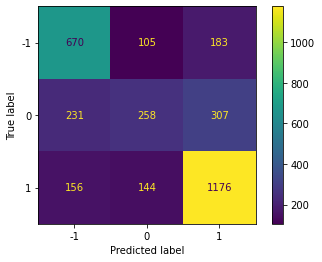

In [27]:
print('KNN')
plot_confusion_matrix(knn_clf, X_train, y_train)
plt.show()

SVC


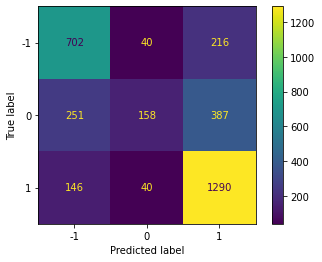

In [28]:
print('SVC')
plot_confusion_matrix(svc_clf, X_train, y_train)
plt.show()

Forest


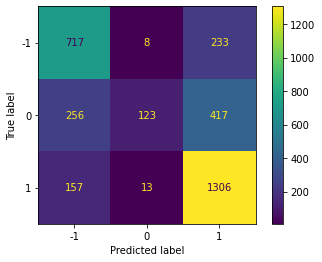

In [29]:
print('Forest')
plot_confusion_matrix(forest_clf, X_train, y_train)
plt.show()

GNB


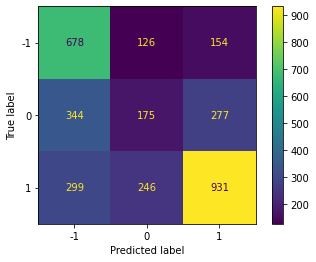

In [30]:
print('GNB')
plot_confusion_matrix(gnb_clf, X_train, y_train)
plt.show()

## Classifcation Reports

#### KNeigborsClassifier

In [31]:
knn_pred = cross_val_predict(knn_clf, X_train, y_train)
print(classification_report(y_train, knn_pred))

              precision    recall  f1-score   support

          -1       0.56      0.61      0.59       958
           0       0.33      0.21      0.25       796
           1       0.65      0.75      0.70      1476

    accuracy                           0.57      3230
   macro avg       0.52      0.52      0.51      3230
weighted avg       0.55      0.57      0.56      3230



#### SVC

In [32]:
svc_pred = cross_val_predict(svc_clf, X_train, y_train)
print(classification_report(y_train, svc_pred))

              precision    recall  f1-score   support

          -1       0.58      0.66      0.62       958
           0       0.32      0.11      0.16       796
           1       0.63      0.80      0.71      1476

    accuracy                           0.59      3230
   macro avg       0.51      0.52      0.50      3230
weighted avg       0.54      0.59      0.55      3230



#### Forest

In [33]:
forest_pred = cross_val_predict(forest_clf, X_train, y_train)
print(classification_report(y_train, forest_pred))

              precision    recall  f1-score   support

          -1       0.58      0.69      0.63       958
           0       0.27      0.05      0.08       796
           1       0.63      0.84      0.72      1476

    accuracy                           0.60      3230
   macro avg       0.50      0.53      0.48      3230
weighted avg       0.53      0.60      0.54      3230



In [34]:
gnb_pred = cross_val_predict(gnb_clf, X_train, y_train)
print(classification_report(y_train, gnb_pred))

              precision    recall  f1-score   support

          -1       0.51      0.71      0.60       958
           0       0.31      0.21      0.25       796
           1       0.68      0.62      0.65      1476

    accuracy                           0.55      3230
   macro avg       0.50      0.52      0.50      3230
weighted avg       0.54      0.55      0.54      3230



## Hyperparameter tuning

#### KneighborsClassifier

In [35]:
param_grid = [
    {'n_neighbors': range(1, 20), 'weights': ['uniform', 'distance']}
]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': range(1, 20),
                          'weights': ['uniform', 'distance']}])

In [36]:
grid_search.best_params_

{'n_neighbors': 16, 'weights': 'uniform'}

In [37]:
knn_clf = grid_search.best_estimator_.fit(X_train, y_train)
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=3)
print('KNN Train Score: {}'.format(knn_clf.score(X_train, y_train)))
print('Cross Validated KNN mean score: {}'.format(knn_scores.mean()))

KNN Train Score: 0.6362229102167183
Cross Validated KNN mean score: 0.5854506586403325


In [38]:
knn_pred = cross_val_predict(knn_clf, X_train, y_train)
print(classification_report(y_train, knn_pred))

              precision    recall  f1-score   support

          -1       0.57      0.64      0.61       958
           0       0.35      0.17      0.23       796
           1       0.65      0.78      0.71      1476

    accuracy                           0.59      3230
   macro avg       0.52      0.53      0.51      3230
weighted avg       0.55      0.59      0.56      3230



#### SVC

In [39]:
param_grid = [
    {'C': range(1, 20)}
]

svc_clf = SVC()
grid_search = GridSearchCV(svc_clf, param_grid, cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(), param_grid=[{'C': range(1, 20)}])

In [40]:
grid_search.best_params_

{'C': 1}

In [41]:
svc_clf = grid_search.best_estimator_.fit(X_train, y_train)
svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=3)
print('SVC Train Score: {}'.format(svc_clf.score(X_train, y_train)))
print('Cross Validated SVC mean score: {}'.format(svc_scores.mean()))

SVC Train Score: 0.6294117647058823
Cross Validated SVC mean score: 0.6027856303767292


In [42]:
svc_pred = cross_val_predict(svc_clf, X_train, y_train)
print(classification_report(y_train, svc_pred))

              precision    recall  f1-score   support

          -1       0.58      0.68      0.63       958
           0       0.38      0.06      0.10       796
           1       0.63      0.85      0.73      1476

    accuracy                           0.60      3230
   macro avg       0.53      0.53      0.48      3230
weighted avg       0.55      0.60      0.54      3230



In [102]:
gnb_model = gnb_clf
svc_model = svc_clf
knn_model = knn_clf
forest_model = forest_clf
pickle.dump(gnb_model, open('gnb_model.pkl', 'wb'))
pickle.dump(svc_model, open('svc_model.pkl', 'wb'))
pickle.dump(knn_model, open('knn_model.pkl', 'wb'))
pickle.dump(forest_model, open('forest_model.pkl', 'wb'))

In [100]:
model = pickle.load(open('model.pkl', 'rb'))
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.54      0.79      0.64       169
           0       0.31      0.19      0.23       140
           1       0.72      0.66      0.69       261

    accuracy                           0.58       570
   macro avg       0.52      0.54      0.52       570
weighted avg       0.57      0.58      0.56       570



# Prediction Pipeline

In [72]:
class FeatureEngineerAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        HAS = X['HTG'] / X['num_games'] / X['avg_hs']
        AAS = X['ATG'] / X['num_games'] / X['avg_as']
        HDS = X['HTC'] / X['num_games'] / X['avg_ac']
        ADS = X['ATC'] / X['num_games'] / X['avg_hc']
        HXG = HAS * ADS * X['avg_hs']
        AXG = AAS * HDS * X['avg_as']
        PastGoalDiff = X['PastFTHG'] - X['PastFTAG']
        PastShotsDiff = X['PastHS'] - X['PastAS']
        PastShotsOnTargetDiff = X['PastHST'] - X['PastAST']
        
        return np.c_[HAS, AAS, HDS, ADS, HXG, AXG, PastGoalDiff, PastShotsDiff, PastShotsOnTargetDiff]

In [83]:
def extract_data(data, fixtures):
    
    df = pd.DataFrame(columns=['num_games', 'HTG', 'ATG', 'HTC', 'ATC', 
                               'avg_hs', 'avg_as', 'avg_hc', 'avg_ac',
                              'PastFTHG', 'PastFTAG', 'PastHS', 'PastAS', 'PastHST', 'PastAST']) 
    
    df.num_games = [data.shape[0] / 20] * len(fixtures)
    df.avg_hs = [data.FTHG.sum() / data.shape[0]] * len(fixtures)
    df.avg_as = [data.FTAG.sum() / data.shape[0]] * len(fixtures)
    df.avg_hc = df.avg_as
    df.avg_ac = df.avg_hs
    
    HTG = []
    ATG = []
    HTC = []
    ATC = []
    PastFTHG = []
    PastFTAG = []
    PastHS = []
    PastAS = []
    PastHST = []
    PastAST = []
    
    for fixture in fixtures:
        ht = fixture.ht
        at = fixture.at
        
        average_ht_goals = data.FTHG.sum() / data.shape[0]
        average_at_goals = data.FTAG.sum() / data.shape[0]
        average_ht_conceded = average_at_goals
        average_at_conceded = average_ht_goals    

        ht_group = data.groupby('HomeTeam')
        at_group = data.groupby('AwayTeam')
        ht_data = ht_group.get_group(ht)
        at_data = at_group.get_group(at)
        HTG.append(ht_data.FTHG.sum())
        ATG.append(at_data.FTAG.sum())
        HTC.append(ht_data.FTAG.sum())
        ATC.append(at_data.FTHG.sum())   
        
        ht_stats = data[(data.HomeTeam == ht) | (data.AwayTeam == ht)].tail(3)
        at_stats = data[(data.HomeTeam == at) | (data.AwayTeam == at)].tail(3)
        
        PastFTHG.append(ht_stats[ht_stats.HomeTeam == ht].FTHG.sum() + ht_stats[ht_stats.AwayTeam == ht].FTAG.sum())
        PastFTAG.append(at_stats[at_stats.HomeTeam == at].FTHG.sum() + at_stats[at_stats.AwayTeam == at].FTAG.sum())
        PastHS.append(ht_stats[ht_stats.HomeTeam == ht].HS.sum() + ht_stats[ht_stats.AwayTeam == ht].AS.sum())
        PastAS.append(at_stats[at_stats.HomeTeam == at].HS.sum() + at_stats[at_stats.AwayTeam == at].AS.sum())
        PastHST.append(ht_stats[ht_stats.HomeTeam == ht].HST.sum() + ht_stats[ht_stats.AwayTeam == ht].AST.sum())
        PastAST.append(at_stats[at_stats.HomeTeam == at].HST.sum() + at_stats[at_stats.AwayTeam == at].AST.sum())
        
    df.HTG = HTG
    df.ATG = ATG
    df.HTC = HTC
    df.ATC = ATC
    df.PastFTHG = PastFTHG
    df.PastFTAG = PastFTAG
    df.PastHS = PastHS
    df.PastAS = PastAS
    df.PastHST = PastHST
    df.PastAST = PastAST
    
    return df

In [86]:
pipeline = Pipeline(
    steps=[
        ('feature_engineer_adder', FeatureEngineerAdder()),
        ('std_scaler', pickle.load(open('myscaler.pkl', 'rb')))
    ]
)

In [126]:
E0 = pd.read_csv('E0.csv')
E0.HomeTeam.unique()

array(['Fulham', 'Crystal Palace', 'Liverpool', 'West Ham', 'West Brom',
       'Tottenham', 'Brighton', 'Sheffield United', 'Everton', 'Leeds',
       'Man United', 'Arsenal', 'Southampton', 'Newcastle', 'Chelsea',
       'Leicester', 'Aston Villa', 'Wolves', 'Burnley', 'Man City'],
      dtype=object)

In [127]:
Fixture = namedtuple('Fixture', 'ht at')
fix_1 = Fixture('Burnley', 'Arsenal')
fix_2 = Fixture('Sheffield United', 'Southampton')
fix_3 = Fixture('Aston Villa', 'Wolves')
fix_4 = Fixture('Brighton', 'Leicester')
fixtures = [fix_1, fix_2, fix_3, fix_4]
test_data = extract_data(E0, fixtures)
test_data

,num_games,HTG,ATG,HTC,ATC,avg_hs,avg_as,avg_hc,avg_ac,PastFTHG,PastFTAG,PastHS,PastAS,PastHST,PastAST
0,13.25,11,18,15,13,1.324528,1.30566,1.30566,1.324528,1,7,28,32,11,10
1,13.25,10,14,20,28,1.324528,1.30566,1.30566,1.324528,1,1,21,26,6,7
2,13.25,20,13,16,23,1.324528,1.30566,1.30566,1.324528,2,3,36,35,10,10
3,13.25,12,26,17,12,1.324528,1.30566,1.30566,1.324528,1,4,66,39,20,14


In [121]:
def transform_ftr_back(row, column_name):
    if row[column_name] == 1:
        return 'H'
    if row[column_name] == -1:
        return 'A'
    else:
        return 'D'

In [128]:
test_data_tr = pipeline.transform(test_data)
gnb_prediction = gnb_clf.predict(test_data_tr)
svc_prediction = svc_clf.predict(test_data_tr)
knn_prediction = knn_clf.predict(test_data_tr)
forest_prediction = forest_clf.predict(test_data_tr)

df = pd.DataFrame(columns=['HomeTeam', 'AwayTeam', 'GNB', 'SVC', 'KNN', 'Forest'])
home_teams = []
away_teams = []
for fixture in fixtures:
    home_teams.append(fixture.ht)
    away_teams.append(fixture.at)

df['HomeTeam'] = home_teams
df['AwayTeam'] = away_teams

df['GNB'] = gnb_prediction
df['SVC'] = svc_prediction
df['KNN'] = knn_prediction
df['Forest'] = forest_prediction

df.GNB = df.apply(lambda row: transform_ftr_back(row, 'GNB'), axis=1)
df.SVC = df.apply(lambda row: transform_ftr_back(row, 'SVC'), axis=1)
df.KNN = df.apply(lambda row: transform_ftr_back(row, 'KNN'), axis=1)
df.Forest = df.apply(lambda row: transform_ftr_back(row, 'Forest'), axis=1)
df

,HomeTeam,AwayTeam,GNB,SVC,KNN,Forest
0,Burnley,Arsenal,A,A,A,A
1,Sheffield United,Southampton,A,A,H,H
2,Aston Villa,Wolves,D,A,A,A
3,Brighton,Leicester,D,A,A,A
